In [1]:
# Install all the required libraries
!pip install -U -q pdfplumber tiktoken openai chromaDB sentence-transformers langgraph langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.0/607.0 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 17.7 MB/s eta 0

In [2]:
!pip install langchain

In [3]:
!pip install langgraph

In [4]:
!pip install langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.3 MB/s eta 0:00:00


In [7]:
from typing import Literal
from pathlib import Path
import pandas as pd
import pdfplumber
from operator import itemgetter
import json
import openai
import chromadb
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage, AIMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain.memory import ConversationBufferMemory
from langchain_core.messages import RemoveMessage
from langgraph.checkpoint.memory import MemorySaver

In [8]:
# Initialize the memory for the checkpointer
memory = MemorySaver()

In [9]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [10]:
# Define the path to the directory containing the PDF files
pdf_path = "/content/drive/MyDrive/Gen_AI/GK_Doc"


In [11]:
# Function to check if a word is inside a table bbox
def check_bboxes(word, table_bbox):
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [12]:
# Function to extract text from PDFs
def extract_text_from_pdf(pdf_path):
    full_text = []
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {len(full_text) + 1}"
            text = page.extract_text()
            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []
            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):
                # Check if the item in the cluster is a word dictionary or a table dictionary
                if 'text' in cluster[0]:  # Word dictionary
                    lines.append(' '.join([i['text'] for i in cluster if 'text' in i]))
                elif 'table' in cluster[0]:  # Table dictionary
                    lines.append(json.dumps(cluster[0]['table']))
            full_text.append([page_no, " ".join(lines)])
    return full_text

In [13]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

In [14]:
# Initialize an empty list to store the extracted texts and document names
data = []

In [15]:
# Loop through all files in the directory and extract text
for pdf_path in pdf_directory.glob("*.pdf"):
    print(f"...Processing {pdf_path.name}")
    extracted_text = extract_text_from_pdf(pdf_path)
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name
    data.append(extracted_text_df)
    print(f"Finished processing {pdf_path.name}")


...Processing GK_Doc1.pdf
Finished processing GK_Doc1.pdf
...Processing GK_Doc2.pdf
Finished processing GK_Doc2.pdf
...Processing GK_Doc3.pdf
Finished processing GK_Doc3.pdf


In [16]:

print("All PDFs have been processed.")
gk_pdfs_data = pd.concat(data, ignore_index=True)

All PDFs have been processed.


In [17]:

# Clean and filter data
gk_pdfs_data['Text_Length'] = gk_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))
gk_pdfs_data = gk_pdfs_data.loc[gk_pdfs_data['Text_Length'] >= 10]

In [18]:
# Add metadata
gk_pdfs_data['Metadata'] = gk_pdfs_data.apply(lambda x: {'Document_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

In [19]:
# Set OpenAI API key for LangChain use
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
openai.api_key = os.environ["OPENAI_API_KEY"]

OPENAI_API_KEY: ··········


In [20]:
# Set up ChromaDB and embedding function
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction
client = chromadb.PersistentClient()
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name="text-embedding-ada-002")

In [21]:
# Create or retrieve ChromaDB collection
gk_collection = client.get_or_create_collection(name="gk_collection", embedding_function=embedding_function)

In [22]:
# Add the extracted page text and metadata to the ChromaDB collection
documents_list = gk_pdfs_data["Page_Text"].tolist()
metadata_list = gk_pdfs_data['Metadata'].tolist()
gk_collection.add(
    documents=documents_list,
    ids=[str(i) for i in range(len(documents_list))],
    metadatas=metadata_list
)


In [23]:
# Custom retrieval function using ChromaDB
def chroma_retriever(query: str, collection: chromadb.api.models.Collection, n_results: int = 10):
    results = collection.query(query_texts=[query], n_results=n_results)
    documents = results['documents'][0] if 'documents' in results else []
    metadatas = results['metadatas'][0] if 'metadatas' in results else []
    return documents, metadatas

# Initialize Chat Model (OpenAI GPT)
chat_model = ChatOpenAI(model_name="gpt-4o-mini")

# Retrieval tool definition using the retriever
from langchain.tools import Tool

retriever_tool = Tool.from_function(
    func=lambda query: chroma_retriever(query, gk_collection),
    name="retrieve_pdfs",
    description="Retrieve relevant information from PDF documents related to antenatal wellness."
)

# Define a custom state for summarization and conversation
class State(MessagesState):
    summary: str

# Summarization function
def summarize_conversation(state: State):
    summary_message = "Summarize the following conversation: " + state["messages"][0].content
    response = chat_model([HumanMessage(content=summary_message)])
    return {"summary": response.content}

# Conditional logic to determine when to summarize
def should_continue(state: State) -> Literal["summarize_conversation", "retrieve", END]: # Modified to include 'retrieve'
    if len(state["messages"]) > 6:
        return "summarize_conversation"
    else:
        return "retrieve" # Added to trigger retrieval after conversation
    # return END # Removed to prevent premature ending


# Agent logic to process input using the chat model
def agent(state: MessagesState):
    response = chat_model([SystemMessage(content="Handle user query.")]+state["messages"])
    return {"messages": [response]}

# Document retrieval node
def retrieve(state: MessagesState):
    query = state["messages"][-1].content
    documents, metadatas = retriever_tool(query)
    retrieved_messages = [AIMessage(content=f"Document: {doc}\nMetadata: {meta}") for doc, meta in zip(documents, metadatas)]
    return {"messages": retrieved_messages}

# Workflow definition
workflow = StateGraph(State)
workflow.add_node("conversation", agent)
workflow.add_node("retrieve", retrieve)
workflow.add_node("summarize_conversation", summarize_conversation)

# Adding workflow edges and logic
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue) # Now includes 'retrieve' as a possible transition
workflow.add_edge("summarize_conversation", END)
# workflow.add_edge("retrieve", END) # Removed, as 'retrieve' is now conditionally called
workflow.add_edge("retrieve", "conversation") # Added to create a loop back to conversation after retrieval


# Compiling the workflow with a memory checkpointer
app = workflow.compile(checkpointer=memory)

<ipython-input-23-7fb681795723>:9: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  chat_model = ChatOpenAI(model_name="gpt-4o-mini")


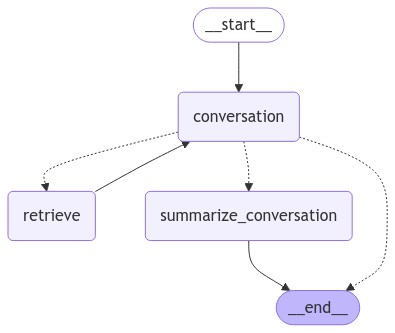

In [24]:
# Import the Image class from IPython.display
from IPython.display import Image
from langchain.schema import HumanMessage, SystemMessage
# Show
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [25]:
# Example of zero-shot prompting
input_message = HumanMessage(content="What are some Ayurvedic remedies for nausea during pregnancy?")
response = chat_model([input_message])
response.pretty_print()


<ipython-input-25-c9bc4dbfc9c0>:3: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = chat_model([input_message])


================================== Ai Message ==================================

Ayurveda offers various natural remedies to help alleviate nausea during pregnancy, often referred to as "morning sickness." Here are some Ayurvedic approaches that may be beneficial:

1. **Ginger**: Ginger is widely recognized for its ability to relieve nausea. You can consume ginger tea, chew on fresh ginger slices, or take ginger candies. 

2. **Lemon**: The scent of lemon can help reduce nausea. You can drink lemon water or suck on lemon slices. 

3. **Peppermint**: Peppermint tea or peppermint oil can be soothing for the stomach. Inhale peppermint oil or drink herbal tea infused with peppermint leaves.

4. **Fennel Seeds**: Chewing on fennel seeds or drinking fennel tea can help in digestion and alleviate nausea.

5. **Cumin Seeds**: Cumin can help with digestive issues. You can boil cumin seeds in water and drink the strained water.

6. **Coriander**: Coriander seeds can also be used to make tea, wh

In [26]:
# Few-shot prompting with examples
examples = [
    HumanMessage(content="Suggest Ayurvedic remedies for headache."),
    AIMessage(content="For headaches, consider using Brahmi or applying a paste made from sandalwood."),
    HumanMessage(content="Suggest Ayurvedic remedies for back pain."),
    AIMessage(content="Use Mahanarayan oil for massage or take Ashwagandha powder for pain relief."),
]

# Adding user query after the few-shot examples
input_message = HumanMessage(content="Suggest Ayurvedic remedies for labor pain.")
response = chat_model(examples + [input_message])
response.pretty_print()


================================== Ai Message ==================================

Here are some Ayurvedic remedies that may help alleviate labor pain:

1. **Warm Compress**: Apply a warm compress to the lower back and abdomen to help ease tension and discomfort.

2. **Ginger Tea**: Ginger has anti-inflammatory properties. Drinking ginger tea may help alleviate pain and promote relaxation.

3. **Turmeric Milk**: Turmeric has natural pain-relieving properties. A warm glass of milk with turmeric can be soothing.

4. **Massage with Oils**: Using oils like Mahanarayan oil or sesame oil for gentle massage can help relieve muscle tension and pain.

5. **Breathing Techniques**: Pranayama (breath control) can help manage pain and anxiety during labor. Deep, controlled breathing can be very beneficial.

6. **Herbal Supplements**: Consult with an Ayurvedic practitioner for specific herbal formulations that may be suited to your needs, such as Ashwagandha or Shatavari.

7. **Acupressure**: Applyin

In [27]:
# Instruction-based prompting
instruction_message = SystemMessage(content="Provide Ayurvedic remedies in a step-by-step format with explanations.")
input_message = HumanMessage(content="Suggest remedies for emotional well-being during the second trimester.")
response = chat_model([instruction_message, input_message])
response.pretty_print()


================================== Ai Message ==================================

During the second trimester of pregnancy, emotional well-being is crucial for both the mother and the developing baby. Ayurvedic remedies focus on balancing the doshas (Vata, Pitta, Kapha) and promoting overall mental and emotional health. Here’s a step-by-step guide to enhance emotional well-being during this stage:

### Step 1: Diet Modification

**Explanation:** A balanced diet helps stabilize mood and energy levels.

- **Include Vata-pacifying foods:** Focus on warm, moist, and nourishing foods. Incorporate whole grains (like rice and oatmeal), cooked root vegetables (like sweet potatoes and carrots), and healthy fats (like ghee and nuts).
  
- **Hydrate:** Drink warm herbal teas, such as chamomile or ginger tea, to soothe the mind and body.

- **Avoid:** Limit caffeine, processed foods, and overly spicy or sour foods to prevent aggravating Vata dosha, which can lead to anxiety and restlessness.

### 

In [28]:
# Chain-of-thought prompting example
input_message = HumanMessage(content="How should one approach Ayurvedic meditation for stress relief during pregnancy? Explain step by step.")
response = chat_model([input_message])
response.pretty_print()


================================== Ai Message ==================================

Ayurvedic meditation can be a beneficial practice for stress relief during pregnancy, promoting both mental well-being and physical relaxation. Here’s a step-by-step approach to practicing Ayurvedic meditation during this special time:

### Step 1: Create a Comfortable Space
- **Choose a Quiet Place**: Find a tranquil space in your home where you can meditate without distractions. This might be a corner of your bedroom or any peaceful area.
- **Set Up Your Space**: Use comfortable cushions or a yoga mat to sit on. You may want to light a candle or incense, and consider adding calming elements, such as soft music or nature sounds.

### Step 2: Choose the Right Time
- **Pick a Time**: Find a time each day when you can dedicate yourself to meditation, ideally when you’re less likely to be interrupted (early morning or late evening can be ideal).
- **Be Consistent**: Consistency helps in building a habit, so 

In [29]:
# Context-based prompting with ChromaDB retrieval
query = "Ayurvedic remedies for postpartum care"
documents, metadatas = chroma_retriever(query, gk_collection)
contextual_message = "\n\n".join([f"Document: {doc}\nMetadata: {meta}" for doc, meta in zip(documents, metadatas)])

# Adding context to the prompt
input_message = HumanMessage(content=f"Based on the following documents, suggest Ayurvedic remedies for postpartum care:\n\n{contextual_message}")
response = chat_model([input_message])
response.pretty_print()


================================== Ai Message ==================================

Based on the documents provided, here are some Ayurvedic remedies and practices recommended for postpartum care:

### Ayurvedic Remedies for Postpartum Care:

1. **Dietary Recommendations**:
   - **Nutritious Foods**: Incorporate nourishing foods such as ghee, warm milk, and fresh fruits. Foods rich in iron and protein, like lentils and leafy greens, are beneficial for recovery.
   - **Warm Spices**: Use spices like ginger, turmeric, and black pepper, known for their anti-inflammatory properties, which can aid in digestion and healing.
   - **Postpartum Specific Foods**: Consider consuming special postpartum dishes such as warm porridge made with oats or rice and flavored with cardamom and nuts.

2. **Herbal Supplements**:
   - **Ashwagandha**: This adaptogenic herb can help in reducing stress and promoting overall vitality.
   - **Shatavari**: Known for its benefits in women’s health, it can help restore

In [30]:
def evaluate_response(response_text: str, evaluation_criteria: dict) -> dict:
    """
    Evaluates the response text based on provided criteria.
    evaluation_criteria should be a dict with keys 'relevance', 'completeness', and 'accuracy'.
    """
    evaluation_results = {}
    for criterion, weight in evaluation_criteria.items():
        score = input(f"Rate the {criterion} (1-10) for the following response:\n\n{response_text}\n\nScore: ")
        evaluation_results[criterion] = int(score) * weight
    return evaluation_results

# Example evaluation criteria
criteria = {
    "relevance": 0.4,
    "completeness": 0.3,
    "accuracy": 0.3
}

# Evaluating a response
response_text = response.content
evaluation = evaluate_response(response_text, criteria)
print(f"Evaluation results: {evaluation}")


Rate the relevance (1-10) for the following response:

Based on the documents provided, here are some Ayurvedic remedies and practices recommended for postpartum care:

### Ayurvedic Remedies for Postpartum Care:

1. **Dietary Recommendations**:
   - **Nutritious Foods**: Incorporate nourishing foods such as ghee, warm milk, and fresh fruits. Foods rich in iron and protein, like lentils and leafy greens, are beneficial for recovery.
   - **Warm Spices**: Use spices like ginger, turmeric, and black pepper, known for their anti-inflammatory properties, which can aid in digestion and healing.
   - **Postpartum Specific Foods**: Consider consuming special postpartum dishes such as warm porridge made with oats or rice and flavored with cardamom and nuts.

2. **Herbal Supplements**:
   - **Ashwagandha**: This adaptogenic herb can help in reducing stress and promoting overall vitality.
   - **Shatavari**: Known for its benefits in women’s health, it can help restore hormonal balance and impro

In [31]:
# Example user interaction
input_message = HumanMessage(content="Suggest Ayurvedic remedies for labor pain.")
config = {"configurable": {"thread_id": "2"}, "recursion_limit": 10}

for event in app.stream(
    {"messages": [input_message]},
    config,
    stream_mode="values"
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Suggest Ayurvedic remedies for labor pain.
================================== Ai Message ==================================

Ayurvedic remedies can provide some relief for labor pain, focusing on natural methods to ease discomfort and promote relaxation. Here are some suggestions:

1. **Herbal Teas**: 
   - **Ginger Tea**: Ginger has anti-inflammatory properties and can help alleviate pain. 
   - **Raspberry Leaf Tea**: Often used to strengthen the uterus and may help in reducing labor pain.

2. **Essential Oils**: 
   - **Lavender Oil**: Known for its calming properties, it can help reduce anxiety and promote relaxation.
   - **Clary Sage Oil**: Traditionally used in labor for its potential to relieve pain and facilitate contractions.

3. **Warm Compress**: 
   - Applying a warm compress or heating pad on the lower back can help soothe discomfort.

4. **Massage**: 
   - Gentle massage with warm oils like

<ipython-input-23-7fb681795723>:47: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  documents, metadatas = retriever_tool(query)


================================== Ai Message ==================================

When considering Ayurvedic remedies for managing labor pain, it's important to consult with a healthcare professional, especially during pregnancy and childbirth. Here are some Ayurvedic approaches that may help alleviate discomfort during labor:

### 1. **Herbal Remedies**
   - **Ginger (Zingiber officinale)**: Known for its anti-inflammatory properties, ginger can be consumed as tea or in food to help ease pain.
   - **Raspberry Leaf (Rubus idaeus)**: Often used to strengthen the uterine muscles and may help in reducing labor pain. You can brew it as a tea.
   - **Turmeric (Curcuma longa)**: Turmeric milk (golden milk) can help reduce inflammation and discomfort.

### 2. **Essential Oils**
   - **Lavender Oil**: Known for its calming effects; it can be used in diffusers or diluted and massaged onto the skin to relieve stress and discomfort.
   - **Clary Sage Oil**: Traditionally used during labor; it ma

In [32]:
# Example user interaction
input_message = HumanMessage(content="Suggest Ayurvedic remedies for nutrition and diet.")
config = {"configurable": {"thread_id": "2"}, "recursion_limit": 10}

for event in app.stream(
    {"messages": [input_message]},
    config,
    stream_mode="values"
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Suggest Ayurvedic remedies for nutrition and diet.
================================== Ai Message ==================================

Ayurvedic nutrition emphasizes a balanced diet tailored to an individual's unique constitution (Prakriti), seasonal changes, and overall health. Here are some Ayurvedic remedies and dietary recommendations:

### 1. **Whole Foods**
   - **Fresh Fruits and Vegetables**: Incorporate a variety of seasonal fruits and vegetables. They provide essential vitamins, minerals, and antioxidants. Favor sweet, bitter, and astringent tastes to balance the body's doshas.
   - **Whole Grains**: Opt for whole grains like brown rice, quinoa, barley, and millet. These are easier to digest and provide sustained energy.

### 2. **Spices and Herbs**
   - **Turmeric**: Known for its anti-inflammatory properties, turmeric can be added to dishes or taken with warm milk.
   - **Ginger**: Aids digestio

In [33]:
# Example user interaction
input_message = HumanMessage(content="Suggest Ayurvedic remedies for emotional well being for 2nd trimester pregnancy.")
config = {"configurable": {"thread_id": "2"}, "recursion_limit": 10}

for event in app.stream(
    {"messages": [input_message]},
    config,
    stream_mode="values"
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Suggest Ayurvedic remedies for emotional well being for 2nd trimester pregnancy.
================================== Ai Message ==================================

During the second trimester of pregnancy, emotional well-being is essential for both the mother and the developing baby. Ayurvedic remedies can help balance emotions, reduce stress, and promote overall mental health. Here are some suggestions:

### 1. **Herbal Teas**
   - **Chamomile Tea**: Known for its calming properties, chamomile tea can help reduce anxiety and promote relaxation.
   - **Tulsi (Holy Basil) Tea**: Tulsi is revered in Ayurveda for its adaptogenic properties, helping the body cope with stress.

### 2. **Aromatherapy**
   - **Lavender Essential Oil**: Use lavender oil in a diffuser or add a few drops to a warm bath to promote relaxation and reduce anxiety.
   - **Rose Essential Oil**: Known for its uplifting properties, rose oil

In [34]:
# Example user interaction
input_message = HumanMessage(content="Suggest Ayurvedic remedies for meditation.")
config = {"configurable": {"thread_id": "2"}, "recursion_limit": 10}

for event in app.stream(
    {"messages": [input_message]},
    config,
    stream_mode="values"
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Suggest Ayurvedic remedies for meditation.
================================== Ai Message ==================================

Ayurveda offers various remedies and practices that can enhance meditation, helping to calm the mind, balance emotions, and deepen your meditative experience. Here are some Ayurvedic suggestions for supporting your meditation practice:

### 1. **Herbal Preparations**
   - **Brahmi (Bacopa monnieri)**: Known for its cognitive-enhancing properties, Brahmi can help improve concentration and clarity. You can consume it as a tea or in powdered form mixed with honey.
   - **Ashwagandha (Withania somnifera)**: This adaptogenic herb helps reduce stress and anxiety. It can be taken in powder form mixed with warm milk or water before meditation.
   - **Tulsi (Holy Basil)**: Drinking Tulsi tea before meditation can help calm the mind and enhance spiritual awareness.

### 2. **Essential Oils**


In [35]:
# Example user interaction
input_message = HumanMessage(content="Suggest Ayurvedic remedies for epigenetics.")
config = {"configurable": {"thread_id": "2"}, "recursion_limit": 10}

for event in app.stream(
    {"messages": [input_message]},
    config,
    stream_mode="values"
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Suggest Ayurvedic remedies for epigenetics.
================================== Ai Message ==================================

Epigenetics is the study of how environmental factors and lifestyle choices can influence gene expression without altering the underlying DNA sequence. While Ayurveda does not specifically use the term "epigenetics," it emphasizes the connection between the body, mind, and environment, and offers various remedies that can support overall health and potentially influence gene expression positively. Here are some Ayurvedic approaches that can be considered in the context of epigenetics:

### 1. **Dietary Practices**
   - **Sattvic Diet**: Focus on a Sattvic (pure) diet that includes fresh, organic fruits, vegetables, whole grains, nuts, and seeds. This diet is believed to promote clarity and health, potentially influencing gene expression positively.
   - **Antioxidant-Rich Foods**: 

In [36]:
# Example user interaction
input_message = HumanMessage(content="Suggest Ayurvedic remedies for postpartum care")
config = {"configurable": {"thread_id": "2"}, "recursion_limit": 10}

for event in app.stream(
    {"messages": [input_message]},
    config,
    stream_mode="values"
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Suggest Ayurvedic remedies for postpartum care
================================== Ai Message ==================================

Postpartum care is essential for a new mother’s recovery and well-being. Ayurvedic remedies focus on nourishing the body, promoting healing, and balancing the doshas after childbirth. Here are some Ayurvedic remedies and practices for postpartum care:

### 1. **Dietary Recommendations**
   - **Warm, Nourishing Foods**: Consume warm, easily digestible foods that are rich in nutrients. Focus on soups, stews, and khichdi (a mix of rice and lentils) to aid digestion and provide energy.
   - **Ghee (Clarified Butter)**: Incorporate ghee into your meals for its nourishing properties. It aids digestion and helps in the absorption of nutrients.
   - **Moringa (Drumstick Tree)**: Moringa leaves are highly nutritious and can be added to soups or smoothies to support recovery and enhance m

In [37]:
# Example user interaction
input_message = HumanMessage(content="Suggest Ayurvedic do's and dont's for physical exercises .")
config = {"configurable": {"thread_id": "2"}, "recursion_limit": 10}

for event in app.stream(
    {"messages": [input_message]},
    config,
    stream_mode="values"
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Suggest Ayurvedic do's and dont's for physical exercises .
================================== Ai Message ==================================

When it comes to physical exercise in Ayurveda, it's important to consider your individual constitution (Prakriti), the current season, and your overall health. Here are some general Ayurvedic do's and don'ts for physical exercises:

### Do's

1. **Consult Your Ayurvedic Practitioner**:
   - Before starting any new exercise regimen, consult with a qualified Ayurvedic practitioner to understand what is suitable for your body type and current health condition.

2. **Listen to Your Body**:
   - Pay attention to how your body feels during and after exercise. Adjust your routine based on your energy levels and any discomfort you may experience.

3. **Choose the Right Type of Exercise**:
   - Select exercises that align with your dosha:
     - **Vata**: Gentle exercises li

In [38]:
# Example user interaction
input_message = HumanMessage(content="Give recap of the conversations we had till now")
config = {"configurable": {"thread_id": "2"}, "recursion_limit": 10}

for event in app.stream(
    {"messages": [input_message]},
    config,
    stream_mode="values"
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Give recap of the conversations we had till now
================================== Ai Message ==================================

Certainly! Here’s a recap of the conversations we’ve had:

1. **Ayurvedic Remedies for Labor Pain**: You asked for suggestions on Ayurvedic remedies to alleviate labor pain. I provided various options, including herbal teas (ginger and raspberry leaf), essential oils (lavender and clary sage), warm compresses, massage techniques, breathing techniques, and yoga.

2. **Ayurvedic Remedies for Nutrition and Diet**: You requested Ayurvedic remedies focused on nutrition and diet. I suggested a range of practices such as consuming whole foods, incorporating spices and herbs, healthy fats, dairy products, balanced meals, and seasonal eating.

3. **Ayurvedic Remedies for Emotional Well-being during Second Trimester Pregnancy**: You asked for remedies to support emotional well-being duri